In [ ]:
# Instalar dependências, PyTorch e clonar YOLOv5
!pip install -U pip
!pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu118

!git clone https://github.com/ultralytics/yolov5
%cd yolov5
!pip install -r requirements.txt


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 21.3 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu118
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 31.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 65.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 48.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 20.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 27.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 55.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 53.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 54.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.

Descompactar o zip

In [ ]:
!unzip -q /content/tom-jerry-object-detection.zip -d /content/


unzip:  cannot find or open /content/tom-jerry-object-detection.zip, /content/tom-jerry-object-detection.zip.zip or /content/tom-jerry-object-detection.zip.ZIP.


Criar pastas para YOLOv5

In [ ]:
import os
import shutil

# Fonte das imagens e labels json
train_images_src = '/content/Tom_and_Jerry_Kaggle_dataset/Tom_and_Jerry_Kaggle_dataset/train/images'
train_annotations_path = '/content/Tom_and_Jerry_Kaggle_dataset/Tom_and_Jerry_Kaggle_dataset/train/annotations/train.json'

# Destino esperado pelo YOLOv5
images_train_dest = '/content/tom_jerry/images/train'
labels_train_dest = '/content/tom_jerry/labels/train'

os.makedirs(images_train_dest, exist_ok=True)
os.makedirs(labels_train_dest, exist_ok=True)

# Copiar imagens para pasta correta
print("Copiando imagens de treino...")
for img_file in os.listdir(train_images_src):
    shutil.copy(os.path.join(train_images_src, img_file), images_train_dest)

print(f"Total imagens copiadas: {len(os.listdir(images_train_dest))}")


Copiando imagens de treino...


FileNotFoundError: [Errno 2] No such file or directory: '/content/Tom_and_Jerry_Kaggle_dataset/Tom_and_Jerry_Kaggle_dataset/train/images'

Converter JSON COCO para YOLO TXT (labels)

In [ ]:
import json

def convert_bbox(size, box):
    dw = 1. / size[0]
    dh = 1. / size[1]
    x = box[0] + box[2] / 2.0
    y = box[1] + box[3] / 2.0
    w = box[2]
    h = box[3]
    x = x * dw
    w = w * dw
    y = y * dh
    h = h * dh
    return (x, y, w, h)

print("Convertendo JSON COCO para YOLO...")
with open(train_annotations_path) as f:
    data = json.load(f)

image_id_to_filename = {img['id']: img['file_name'] for img in data['images']}
categories = data['categories']
catid_to_yoloid = {cat['id']: idx for idx, cat in enumerate(categories)}
print("Categorias encontradas:", {idx: cat['name'] for idx, cat in enumerate(categories)})

# Limpa labels
for f in os.listdir(labels_train_dest):
    os.remove(os.path.join(labels_train_dest, f))

for ann in data['annotations']:
    image_id = ann['image_id']
    category_id = ann['category_id']
    bbox = ann['bbox']
    filename = image_id_to_filename[image_id]
    label_filename = os.path.splitext(filename)[0] + '.txt'
    label_path = os.path.join(labels_train_dest, label_filename)

    image_info = next(img for img in data['images'] if img['id'] == image_id)
    width, height = image_info['width'], image_info['height']

    x, y, w, h = convert_bbox((width, height), bbox)

    class_id = catid_to_yoloid[category_id]
    line = f"{class_id} {x:.6f} {y:.6f} {w:.6f} {h:.6f}\n"

    with open(label_path, 'a') as f:
        f.write(line)

print("Conversão finalizada.")


Convertendo JSON COCO para YOLO...
Categorias encontradas: {0: 'Tom', 1: 'Jerry'}
Conversão finalizada.


dividir e as imagens de treino e validacao


In [ ]:
import os
import random
import shutil

# Pastas originais
images_src = '/content/tom_jerry/images/train'
labels_src = '/content/tom_jerry/labels/train'

# Pastas destino para treino e validação
images_train_dest = '/content/tom_jerry_yolo/images/train'
images_val_dest = '/content/tom_jerry_yolo/images/val'
labels_train_dest = '/content/tom_jerry_yolo/labels/train'
labels_val_dest = '/content/tom_jerry_yolo/labels/val'

# Criar pastas se não existirem
os.makedirs(images_train_dest, exist_ok=True)
os.makedirs(images_val_dest, exist_ok=True)
os.makedirs(labels_train_dest, exist_ok=True)
os.makedirs(labels_val_dest, exist_ok=True)

# Listar imagens
all_images = [f for f in os.listdir(images_src) if f.endswith(('.jpg', '.png', '.jpeg'))]

# Embaralhar para divisão aleatória
random.shuffle(all_images)

# Definir proporção para validação (exemplo 20%)
val_ratio = 0.2
val_count = int(len(all_images) * val_ratio)

val_images = all_images[:val_count]
train_images = all_images[val_count:]

def copy_files(image_list, images_dest, labels_dest):
    for img_file in image_list:
        # Copiar imagem
        shutil.copy(os.path.join(images_src, img_file), images_dest)
        # Copiar label (mesmo nome .txt)
        label_file = os.path.splitext(img_file)[0] + '.txt'
        src_label_path = os.path.join(labels_src, label_file)
        if os.path.exists(src_label_path):
            shutil.copy(src_label_path, labels_dest)
        else:
            print(f"Label não encontrada para {img_file}")

# Copiar imagens e labels para treino e val
copy_files(train_images, images_train_dest, labels_train_dest)
copy_files(val_images, images_val_dest, labels_val_dest)

print(f"Total treino: {len(train_images)} imagens")
print(f"Total validação: {len(val_images)} imagens")


Total treino: 582 imagens
Total validação: 145 imagens


Criar arquivo YAML para YOLOv5

In [ ]:
import os

yaml_path = '/content/tom_jerry_yolo/tom_jerry.yaml'
yaml_dir = os.path.dirname(yaml_path)

# Criar a pasta, se não existir
os.makedirs(yaml_dir, exist_ok=True)

categories = [{'id': 0, 'name': 'Tom'}, {'id': 1, 'name': 'Jerry'}]

yaml_content = f"""
train: /content/tom_jerry_yolo/images/train
val: /content/tom_jerry_yolo/images/val

nc: {len(categories)}
names: {[cat['name'] for cat in categories]}
"""

with open(yaml_path, 'w') as f:
    f.write(yaml_content.strip())

print(f"Arquivo YAML criado em: {yaml_path}\n")
print(yaml_content)


with open(yaml_path, 'w') as f:
    f.write(yaml_content.strip())

print(f"Arquivo YAML criado em: {yaml_path}\n")
print(yaml_content)


Arquivo YAML criado em: /content/tom_jerry_yolo/tom_jerry.yaml


train: /content/tom_jerry_yolo/images/train
val: /content/tom_jerry_yolo/images/val

nc: 2
names: ['Tom', 'Jerry']

Arquivo YAML criado em: /content/tom_jerry_yolo/tom_jerry.yaml


train: /content/tom_jerry_yolo/images/train
val: /content/tom_jerry_yolo/images/val

nc: 2
names: ['Tom', 'Jerry']



In [ ]:
import os

print(os.listdir('/content/tom_jerry/images/train'))
print(os.listdir('/content/tom_jerry/labels/train'))



['44b95559-SmittenKitten19522900.jpg', 'e9aafcd5-TheHouseThatCatBuilt20213780.jpg', '023b1cd4-TheHouseThatCatBuilt20213300.jpg', '11f3e968-TheHouseThatCatBuilt20213240.jpg', '537933c5-JerryJerryQuiteContrary19662580.jpg', 'e456f94e-TheMansionCat20013060.jpg', 'dc934448-TheKarateGuard20058280.jpg', 'e63214a8-TomicEnergy19656060.jpg', '42331d7d-OnARoll20214020.jpg', 'cd7dca80-SmittenKitten19525900.jpg', '40438705-JerryJerryQuiteContrary19665040.jpg', 'e2d188e1-AhSweetMouseStoryofLife1965600.jpg', 'a254ba58-frame5600.jpg', 'f36f3811-TomicEnergy19653300.jpg', 'd815bfef-AMouseintheHouse19472800.jpg', '008bf1c7-TheKarateGuard20053180.jpg', 'd791e9b2-TheHouseThatCatBuilt20214500.jpg', '59928803-AMouseintheHouse19478400.jpg', 'ea78df36-SmittenKitten19523400.jpg', '3b73071d-AMouseintheHouse194710600.jpg', '7fb6087f-TheKarateGuard20057620.jpg', '914f1555-TheKarateGuard20056480.jpg', 'fd9b0b80-TheHouseThatCatBuilt20211740.jpg', 'a74c9f7f-JerryJerryQuiteContrary19665580.jpg', '04ac65a1-AhSweetMous

In [ ]:
!git clone https://github.com/ultralytics/yolov5
%cd yolov5
!pip install -r requirements.txt


Cloning into 'yolov5'...
remote: Enumerating objects: 17496, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 17496 (delta 2), reused 0 (delta 0), pack-reused 17491 (from 3)
Receiving objects: 100% (17496/17496), 16.54 MiB | 16.97 MiB/s, done.
Resolving deltas: 100% (11990/11990), done.
/content/yolov5/yolov5/yolov5


In [ ]:
%cd /content/yolov5


/content/yolov5


treinar

In [ ]:
!python train.py --img 640 --batch 16 --epochs 2 --data /content/tom_jerry_yolo/tom_jerry.yaml --weights yolov5s.pt --cache


wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
2025-07-02 16:53:30.920953: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751475210.974655   19162 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751475210.991051   19162 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice: (30 second timeout) 
wandb: W&B disabled due to login timeout.
train: weights=yolov5s.pt, cfg=, data=/content/tom_jerry_yolo/tom_jerry.yaml, 

 Gráficos de perda e métricas

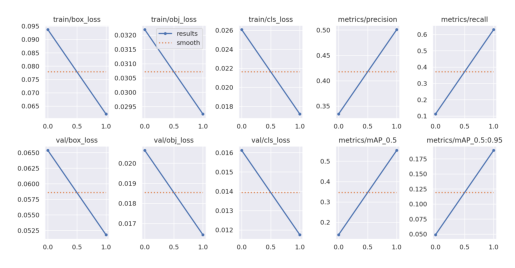

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

img_path = 'runs/train/exp/results.png'
img = Image.open(img_path)

plt.imshow(img)
plt.axis('off')  # tirar os eixos
plt.show()


Métricas detalhadas

Colunas disponíveis:
Index(['               epoch', '      train/box_loss', '      train/obj_loss',
       '      train/cls_loss', '   metrics/precision', '      metrics/recall',
       '     metrics/mAP_0.5', 'metrics/mAP_0.5:0.95', '        val/box_loss',
       '        val/obj_loss', '        val/cls_loss', '               x/lr0',
       '               x/lr1', '               x/lr2'],
      dtype='object')

Primeiras linhas:
                  epoch        train/box_loss        train/obj_loss  \
0                     0              0.093731              0.032194   
1                     1              0.062016              0.029238   

         train/cls_loss     metrics/precision        metrics/recall  \
0              0.026077               0.33433               0.11225   
1              0.017190               0.50094               0.63009   

        metrics/mAP_0.5  metrics/mAP_0.5:0.95          val/box_loss  \
0               0.13865              0.048718              0.065379

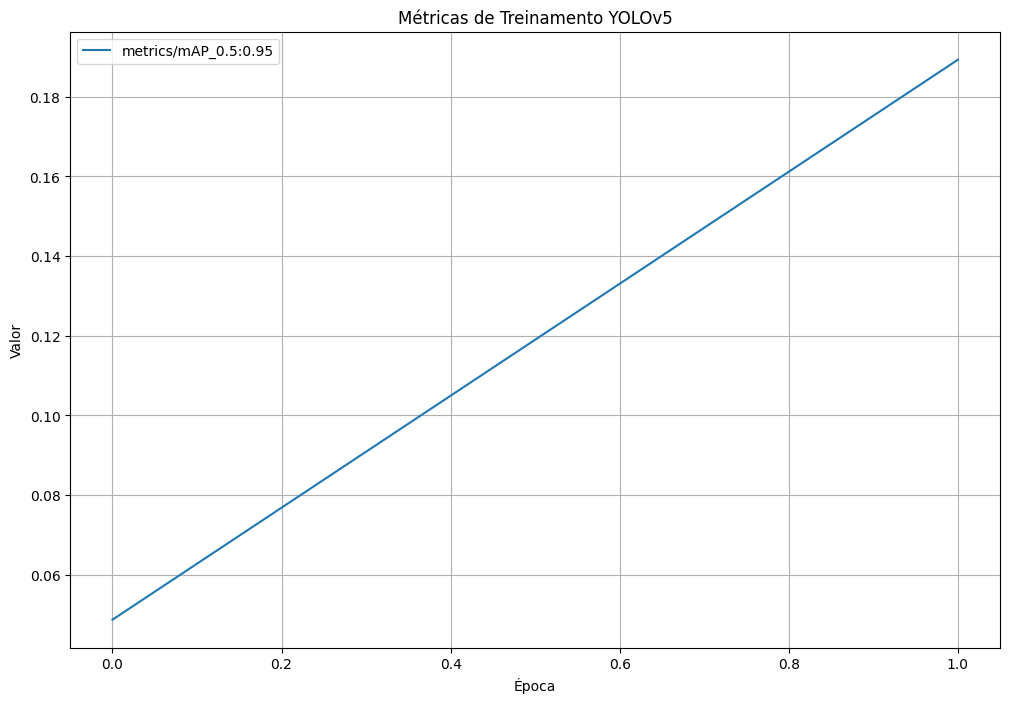

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Caminho para o arquivo results.csv gerado pelo YOLOv5 (ajuste conforme seu caminho)
csv_path = 'runs/train/exp/results.csv'

# Carregar o arquivo CSV
df = pd.read_csv(csv_path)

# Mostrar as colunas disponíveis para entender o que tem no arquivo
print("Colunas disponíveis:")
print(df.columns)

# Verificar as primeiras linhas do dataframe para entender os dados
print("\nPrimeiras linhas:")
print(df.head())

# Plotar as métricas ao longo das épocas (se a coluna 'epoch' existir)
if 'epoch' in df.columns:
    epochs = df['epoch']
else:
    # Caso não exista, pode ser que o índice do DataFrame seja as épocas
    epochs = df.index
    print("\nColuna 'epoch' não encontrada. Usando índice como épocas.")

plt.figure(figsize=(12, 8))

# Plot das perdas de treino e validação (se existirem)
loss_cols = ['train/box_loss', 'train/obj_loss', 'train/cls_loss',
             'val/box_loss', 'val/obj_loss', 'val/cls_loss']
for col in loss_cols:
    if col in df.columns:
        plt.plot(epochs, df[col], label=col)

# Plot dos mapas de precisão (mAP) - métricas importantes de validação
map_cols = ['metrics/mAP_0.5', 'metrics/mAP_0.5:0.95']
for col in map_cols:
    if col in df.columns:
        plt.plot(epochs, df[col], label=col)

plt.xlabel('Época')
plt.ylabel('Valor')
plt.title('Métricas de Treinamento YOLOv5')
plt.legend()
plt.grid(True)
plt.show()



Metricas

In [ ]:
import pandas as pd

results_path = 'runs/train/exp/results.csv'
results = pd.read_csv(results_path)

# Remover espaços em branco dos nomes das colunas
results.columns = [col.strip() for col in results.columns]

print(results.columns)  # Para confirmar os nomes limpos

# Mostrar métricas da última época
last_epoch = results.iloc[-1]

print("Métricas na última época:")
print(last_epoch)

# Agora acessa as métricas sem erro
precision = last_epoch['metrics/precision']
recall = last_epoch['metrics/recall']
mAP_0_5 = last_epoch['metrics/mAP_0.5']

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"mAP@0.5: {mAP_0_5}")



Index(['epoch', 'train/box_loss', 'train/obj_loss', 'train/cls_loss',
       'metrics/precision', 'metrics/recall', 'metrics/mAP_0.5',
       'metrics/mAP_0.5:0.95', 'val/box_loss', 'val/obj_loss', 'val/cls_loss',
       'x/lr0', 'x/lr1', 'x/lr2'],
      dtype='object')
Métricas na última época:
epoch                   1.000000
train/box_loss          0.062016
train/obj_loss          0.029238
train/cls_loss          0.017190
metrics/precision       0.500940
metrics/recall          0.630090
metrics/mAP_0.5         0.553170
metrics/mAP_0.5:0.95    0.189290
val/box_loss            0.051793
val/obj_loss            0.016438
val/cls_loss            0.011749
x/lr0                   0.037555
x/lr1                   0.003321
x/lr2                   0.003321
Name: 1, dtype: float64
Precision: 0.50094
Recall: 0.63009
mAP@0.5: 0.55317


Usar apasta Teste

In [ ]:
import os

test_images_path = '/content/Tom_and_Jerry_Kaggle_dataset/Tom_and_Jerry_Kaggle_dataset/test/images'

# Verifica se o diretório existe
print("Existe?", os.path.exists(test_images_path))

# Lista os primeiros arquivos da pasta
print("Algumas imagens:", os.listdir(test_images_path)[:5])


Existe? True
Algumas imagens: ['e44c3417-frame800.jpg', '5f3cd14f-TheMansionCat20017560.jpg', '976c3615-AMouseintheHouse19475700.jpg', '1d2f9cc6-frame4600.jpg', '9384d998-DesignsOnJerry19554000.jpg']


A inferência

In [ ]:
!python yolov5/detect.py \
  --weights runs/train/exp/weights/best.pt \
  --source /content/Tom_and_Jerry_Kaggle_dataset/Tom_and_Jerry_Kaggle_dataset/test/images \
  --imgsz 640 \
  --conf-thres 0.25 \
  --save-txt \
  --save-conf \
  --project runs/test \
  --name test_run \
  --exist-ok


detect: weights=['runs/train/exp/weights/best.pt'], source=/content/Tom_and_Jerry_Kaggle_dataset/Tom_and_Jerry_Kaggle_dataset/test/images, data=yolov5/data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_format=0, save_csv=False, save_conf=True, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/test, name=test_run, exist_ok=True, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-421-g79c4c31d Python-3.11.13 torch-2.6.0+cu124 CPU

Fusing layers... 
Model summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
image 1/180 /content/Tom_and_Jerry_Kaggle_dataset/Tom_and_Jerry_Kaggle_dataset/test/images/0107031a-AhSweetMouseStoryofLife19655460.jpg: 480x640 1 Tom, 366.3ms
image 2/180 /content/Tom_and_Jerry_Kaggle_dataset/Tom_and_Jerry_Kaggle_dataset/test/images/036051d4-MouseCleanin

In [ ]:
!python yolov5/detect.py \
  --weights runs/train/exp/weights/best.pt \
  --source /content/Tom_and_Jerry_Kaggle_dataset/Tom_and_Jerry_Kaggle_dataset/test/images \
  --conf 0.25 \
  --save-txt --save-conf \
  --project runs/detect \
  --name test_pseudo \
  --exist-ok



detect: weights=['runs/train/exp/weights/best.pt'], source=/content/Tom_and_Jerry_Kaggle_dataset/Tom_and_Jerry_Kaggle_dataset/test/images, data=yolov5/data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_format=0, save_csv=False, save_conf=True, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=test_pseudo, exist_ok=True, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-421-g79c4c31d Python-3.11.13 torch-2.6.0+cu124 CPU

Fusing layers... 
Model summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
image 1/180 /content/Tom_and_Jerry_Kaggle_dataset/Tom_and_Jerry_Kaggle_dataset/test/images/0107031a-AhSweetMouseStoryofLife19655460.jpg: 480x640 1 Tom, 283.6ms
image 2/180 /content/Tom_and_Jerry_Kaggle_dataset/Tom_and_Jerry_Kaggle_dataset/test/images/036051d4-MouseCl

Mostrar imagens

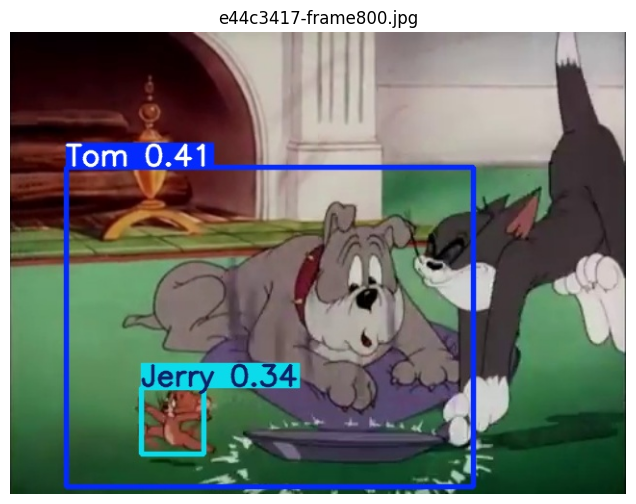

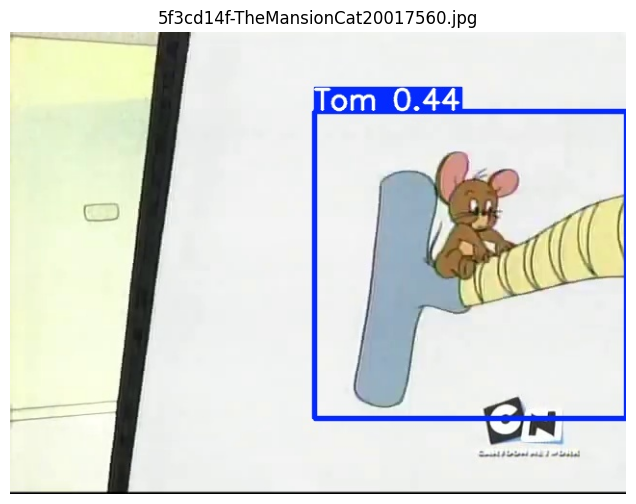

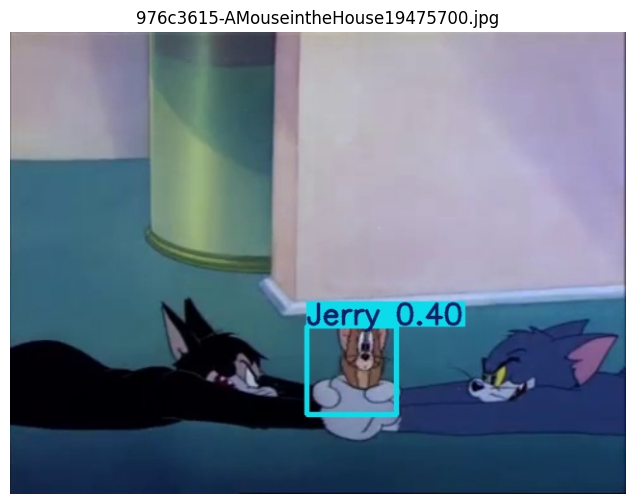

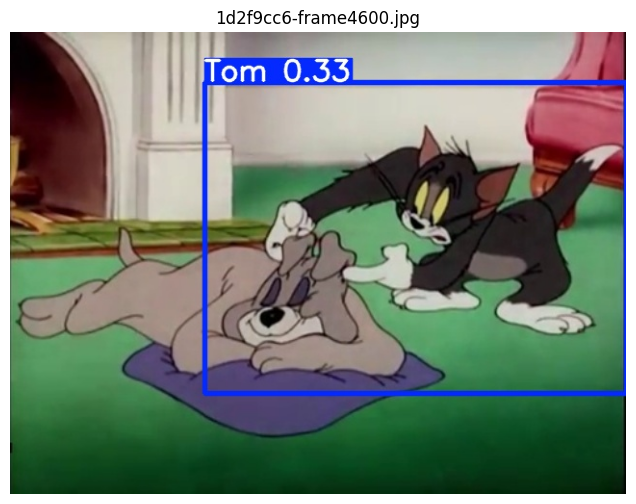

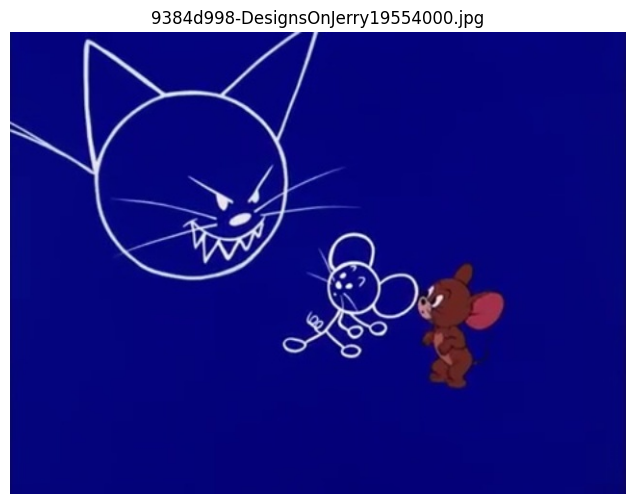

In [ ]:
import os
import matplotlib.pyplot as plt
import cv2

# Caminho dos resultados
result_dir = 'runs/test/test_run'

# Listar algumas imagens
images = [img for img in os.listdir(result_dir) if img.endswith(('.jpg', '.png'))][:5]

# Mostrar imagens
for img_name in images:
    img_path = os.path.join(result_dir, img_name)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10, 6))
    plt.imshow(img)
    plt.title(img_name)
    plt.axis('off')
    plt.show()


In [ ]:
import os
import glob
import numpy as np

def xywh_to_xyxy(box):
    # converte (x_center, y_center, w, h) normalizado para (x1, y1, x2, y2) absoluto (0-1)
    x_c, y_c, w, h = box
    x1 = x_c - w/2
    y1 = y_c - h/2
    x2 = x_c + w/2
    y2 = y_c + h/2
    return [x1, y1, x2, y2]

def iou(box1, box2):
    # box = [x1, y1, x2, y2]
    xA = max(box1[0], box2[0])
    yA = max(box1[1], box2[1])
    xB = min(box1[2], box2[2])
    yB = min(box1[3], box2[3])

    interArea = max(0, xB - xA) * max(0, yB - yA)
    box1Area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2Area = (box2[2] - box2[0]) * (box2[3] - box2[1])

    iou = interArea / (box1Area + box2Area - interArea + 1e-6)
    return iou

def load_boxes_labels(path):
    # carrega boxes do arquivo txt
    boxes = []
    if not os.path.exists(path):
        return boxes
    with open(path, 'r') as f:
        for line in f.readlines():
            parts = line.strip().split()
            cls = int(parts[0])
            box = list(map(float, parts[1:5]))
            boxes.append((cls, box))
    return boxes

def calculate_metrics(gt_dir, pred_dir, iou_threshold=0.5):
    gt_files = glob.glob(os.path.join(gt_dir, '*.txt'))

    TP, FP, FN = 0, 0, 0

    for gt_file in gt_files:
        base_name = os.path.basename(gt_file)
        pred_file = os.path.join(pred_dir, base_name)

        gt_boxes = load_boxes_labels(gt_file)
        pred_boxes = load_boxes_labels(pred_file)

        gt_matched = [False]*len(gt_boxes)
        pred_matched = [False]*len(pred_boxes)

        # para cada predicao tenta casar com gt
        for i, (p_cls, p_box) in enumerate(pred_boxes):
            p_box_xyxy = xywh_to_xyxy(p_box)
            match_found = False
            for j, (g_cls, g_box) in enumerate(gt_boxes):
                if gt_matched[j]:
                    continue
                if p_cls != g_cls:
                    continue
                g_box_xyxy = xywh_to_xyxy(g_box)
                if iou(p_box_xyxy, g_box_xyxy) >= iou_threshold:
                    TP += 1
                    gt_matched[j] = True
                    pred_matched[i] = True
                    match_found = True
                    break
            if not match_found:
                FP += 1

        # contas os gt nao encontrados
        FN += gt_matched.count(False)

    acc = TP / (TP + FP + FN + 1e-6)
    precision = TP / (TP + FP + 1e-6)
    recall = TP / (TP + FN + 1e-6)

    print(f'TP: {TP}, FP: {FP}, FN: {FN}')
    print(f'Accuracy (aprox): {acc:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')

# Ajuste os caminhos abaixo para sua estrutura:
gt_labels_path = '/content/tom_jerry/labels/test'  # onde estão as labels verdadeiras do test
pred_labels_path = '/content/yolov5/runs/test/test_run/labels'  # onde YOLO salvou as predições

calculate_metrics(gt_labels_path, pred_labels_path)



TP: 0, FP: 0, FN: 0
Accuracy (aprox): 0.0000
Precision: 0.0000
Recall: 0.0000


In [ ]:
import os

gt_path = '/content/tom_jerry/labels/test'
pred_path = '/content/yolov5/runs/test/test_run/labels'

print("Labels verdadeiras:", os.listdir(gt_path))
print("Labels preditas:", os.listdir(pred_path))


FileNotFoundError: [Errno 2] No such file or directory: '/content/tom_jerry/labels/test'